## Modeling scRNA-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [83]:
import pandas as pd
import numpy as np
import os
import seaborn
import itertools
import glob

import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [84]:
# these are motifs used during training (pre-weights)
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [85]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [86]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [87]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.Mubind
import torch
import torch
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle


# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [88]:
device = 'cpu'

In [89]:
import scanpy as sc

In [90]:
print('here...')

here...


In [91]:
# pybiomart is requred
annot = sc.queries.biomart_annotations(
    "mmusculus",
    ["ensembl_gene_id", "start_position", "end_position", "chromosome_name"],
).set_index("ensembl_gene_id")
# rna.var[annot.columns] = annot

In [92]:
tss_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'mm10', 'genome', 'TSS.in')
tss = pd.read_csv(tss_path, sep='\t', header=None)
tss.columns = ['chrom', 'pos', 'strand', 'symbol']
tss = tss.set_index('symbol')
tss = tss[~tss.index.duplicated(keep='first')]

In [93]:
# load the pancreas multiome dataset
rna = sc.read_h5ad('noack_et_al_velocity_graph.h5ad')
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')

In [94]:
rna.var[tss.columns] = tss

In [95]:
rna = rna[:,~pd.isnull(rna.var['pos'])].copy()

In [96]:
rna.var['tss_start'] = rna.var['pos'].astype(int)
rna = rna[:,~pd.isnull(rna.var['tss_start'])]
bp = 100
tss_start = rna.var['tss_start'].astype(int)
rna.var['tss_start'] = np.where(rna.var['strand'] == '+', tss_start - bp, tss_start)
rna.var['tss_end'] = np.where(rna.var['strand'] == '+', tss_start, tss_start + bp)

rna.var['chromosome_name'] = rna.var['chrom']
rna.var['k'] = rna.var['chromosome_name'].astype(str) + ':' + rna.var['tss_start'].astype(str) + '-' + rna.var['tss_end'].astype(str)

In [97]:
rna.var['k'] 

index
Xkr4           chr1:3671498-3671598
Rgs20          chr1:5018734-5018834
Slco5a1      chr1:12991135-12991235
Jph1         chr1:17097889-17097989
Mcm3         chr1:20820213-20820313
                     ...           
Sh3kbp1    chrX:159708501-159708601
Rai2       chrX:161717453-161717553
Ap1s2      chrX:163908917-163909017
Ddx3y          chrY:1286613-1286713
Eif2s3y        chrY:1010512-1010612
Name: k, Length: 1948, dtype: object

In [98]:
# rna.shape, atac.shape
# atac_path = '../../../annotations/scatac/noack_et_al_velocity_graph.h5ad'
# os.path.exists(atac_path)
# ad = sc.read_h5ad(atac_path)

In [99]:
ad = rna

In [100]:
ad.var_names

Index(['Xkr4', 'Rgs20', 'Slco5a1', 'Jph1', 'Mcm3', 'Ogfrl1', 'Prim2', 'Bag2',
       'Bend6', 'Aff3',
       ...
       'Kif4', 'Tmem35a', 'Pak3', 'Alas2', 'Smc1a', 'Sh3kbp1', 'Rai2', 'Ap1s2',
       'Ddx3y', 'Eif2s3y'],
      dtype='object', name='index', length=1948)

In [101]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


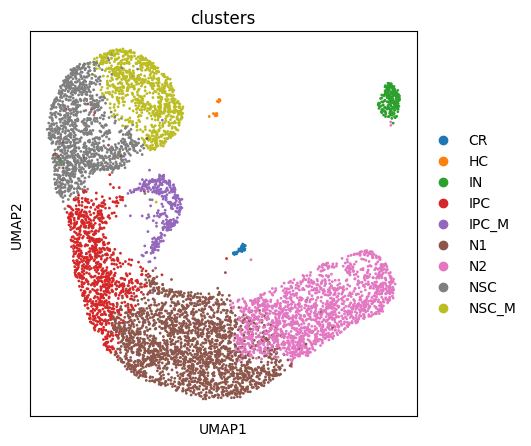

In [102]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='clusters')

#ATAC
# sc.pl.umap(atac, color='celltype')

In [103]:
rna

AnnData object with n_obs × n_vars = 7469 × 1948
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'louvain', 'clusters', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_alignment_scaling', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k'
    uns: 'clusters_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_settings'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau

In [104]:
# scv.pl.velocity_embedding_stream(rna, color='celltype')

(array([ 41.,  50.,  34.,  39.,  49.,  47.,  49.,  54.,  45.,  46.,  50.,
         46.,  62.,  52.,  46.,  50.,  49.,  48.,  45.,  62.,  53.,  56.,
         54.,  51.,  58.,  41.,  55.,  45.,  60.,  47.,  38.,  47.,  86.,
         91., 202.]),
 array([0.00060249, 0.01487099, 0.02913949, 0.04340799, 0.05767649,
        0.07194499, 0.08621349, 0.10048199, 0.11475049, 0.12901899,
        0.14328749, 0.15755599, 0.17182449, 0.18609299, 0.20036149,
        0.21462999, 0.22889849, 0.243167  , 0.2574355 , 0.271704  ,
        0.2859725 , 0.300241  , 0.3145095 , 0.328778  , 0.3430465 ,
        0.357315  , 0.3715835 , 0.385852  , 0.4001205 , 0.414389  ,
        0.4286575 , 0.442926  , 0.4571945 , 0.471463  , 0.4857315 ,
        0.5       ]),
 <BarContainer object of 35 artists>)

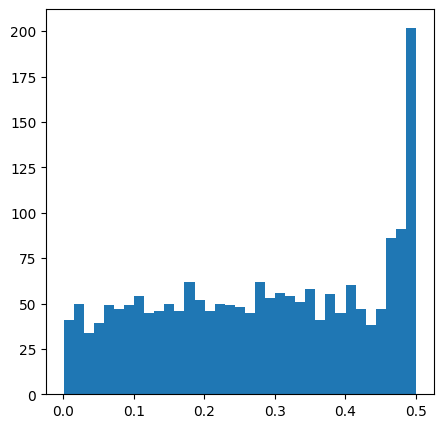

In [105]:
acc = (rna.X != 0).sum(axis=0) / rna.shape[0]
acc_score = abs(.5 - acc)
rna.var['acc_score'] = acc_score.A.T
rna.var['acc_score_rank'] = rna.var['acc_score'].rank(ascending=False)
plt.hist(rna.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [106]:
# n_sample_cells = 750
# n_sample_peaks = 1500

In [107]:
n_cell_types = len(set(rna.obs['clusters']))

In [108]:
n_cell_types

9

In [109]:
rna.shape

(7469, 1948)

In [110]:
rna.obs['clusters'].value_counts()

clusters
N1       2192
N2       1614
NSC      1233
IPC       979
NSC_M     853
IPC_M     337
IN        198
CR         43
HC         20
Name: count, dtype: int64

In [111]:
rna.shape

(7469, 1948)

In [112]:
 # int(n_sample_cells * 1.5)
n_select = 20000
n_sample_cells = n_select
n_sample_peaks = rna.shape[1]
# n_select =  int(n_sample_cells / n_cell_types) # bug if > 20
obs_sample = rna.obs.groupby('clusters').sample(n_select, random_state=n_sample_cells, replace=True).index.drop_duplicates()
var_sample = pd.Series(rna.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = rna[rna.obs_names.isin(obs_sample),rna.var_names.isin(var_sample)].copy()
ad.shape

(7468, 1948)

In [113]:
ad.obs['clusters'].value_counts()

clusters
N1       2191
N2       1614
NSC      1233
IPC       979
NSC_M     853
IPC_M     337
IN        198
CR         43
HC         20
Name: count, dtype: int64

In [114]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [115]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(7468, 7468)

In [116]:
# pip install scvelo

In [117]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

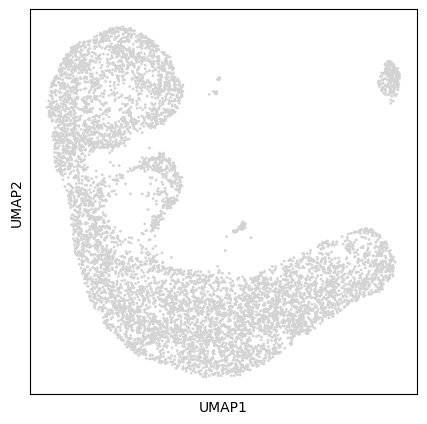

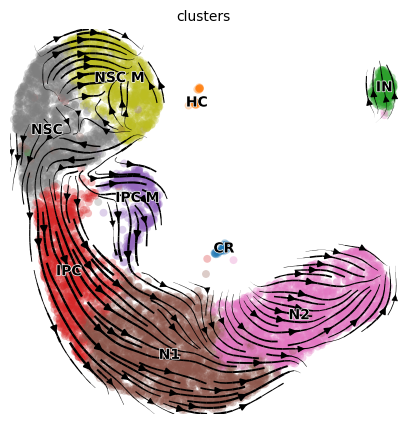

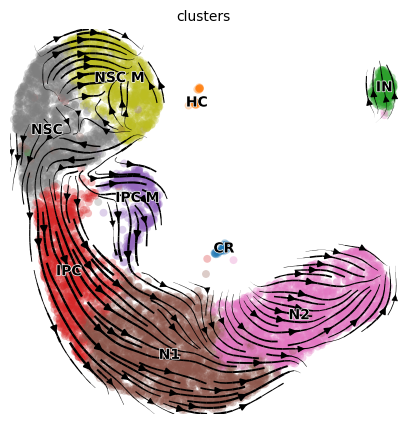

In [118]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [119]:
# ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
# ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
# ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

# print('features by chromosome')
# extend = 50
# ad.var['chr'].value_counts()

In [120]:
# ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
# ad.var['summit.start'] = ad.var['summit'] - extend
# ad.var['summit.end'] = ad.var['summit'] + extend
# ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)
ad.var['chr'] = 'chr' + ad.var['Chromosome'].astype(str)
ad.var['summit.start'] = ad.var['tss_start'].astype(str)
ad.var['summit.end'] = ad.var['tss_end'].astype(str)
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [121]:
ad.shape

(7468, 1948)

In [122]:
!ls /home/ilibarra/miniconda3/envs/mubind/bin/bedtools

/home/ilibarra/miniconda3/envs/mubind/bin/bedtools


In [123]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/miniconda3/envs/mubind/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpz0fgvvrl
genome mm10 True
annotations/mm10/genome/mm10.fa
True annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/miniconda3/envs/mubind/bin/bedtools', 'getfasta', '-fi', 'annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpz0fgvvrl', '-fo', '/tmp/tmp4_acmbf_']
/home/ilibarra/miniconda3/envs/mubind/bin/bedtools getfasta -fi annotations/mm10/genome/mm10.fa -bed /tmp/tmpz0fgvvrl -fo /tmp/tmp4_acmbf_


1948

In [124]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [125]:
counts.shape

(1948, 7468)

In [126]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [127]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [128]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(1948, 7469)

In [129]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(1948, 7469)

In [130]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [131]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [132]:
# next_data.index

In [133]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [134]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [135]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(1948, 7468)

In [136]:
ad.shape, df.shape

((7468, 1948), (1948, 7468))

In [137]:
ad = ad[:,~zero_counts].copy()


In [138]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(14547664, 3)
7468
batch
0      1948
137    1948
127    1948
128    1948
129    1948
       ... 
69     1948
70     1948
71     1948
72     1948
199    1948
Name: count, Length: 200, dtype: int64


,0,1,batch
seq,,,
CCATTGGCCGCCGAGTGTGGGAACGGCCGCGGCGCCCGGACCCCAGGCGCCGGGCCGCTGCCCGCGCCTATATAGGGCTGGCGTGCTGGGGTCCAGGTCG,1.0,2.807686,0
TTGCACGCCTTTAACTGATCCGCGGCGCTGAAGGCGGAGAGACCAGAAGAGGAGTGGCCACAAAGATTGCAATTCTGACATCTTATTGGACCTTTAGGTC,1.0,0.000000,0
CCACGGCAGCCTGCTGGAAAGAGACAAGTTAGTCATTCAAATGATTGGCTTTTTGCCCGCTTCTTCTCTAAATAAGAAGGCAGCAGCTTCTGCTGAGGTG,1.0,4.635506,0
GATAGGGAAAAAATCTGCACCAGCCTTTTACATACAGTAGGTGTGTTTCTCTTCTAGCTGCTCGGGTCTCACTGGCAATCTGTAGAAAGAGCTGTGTTAG,1.0,1.004364,0
AGAAGTCGGATCTGCTTTCGGGGGCGTGTCCATCCTAGCGGAGCGCTCCAACCCTTCCCGGACCCAAGAGGGAGTTTATTGCGCACGCGCGGGGAGGAGC,1.0,4.091436,0


### Simple motif enrichment

In [139]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [140]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [141]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [142]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [143]:
reduced_groups = pwms

In [144]:
df

,0,1,2,3,4,5,6,7,8,9,...,7458,7459,7460,7461,7462,7463,7464,7465,7466,7467
seq,,,,,,,,,,,,,,,,,,,,,
CCATTGGCCGCCGAGTGTGGGAACGGCCGCGGCGCCCGGACCCCAGGCGCCGGGCCGCTGCCCGCGCCTATATAGGGCTGGCGTGCTGGGGTCCAGGTCG,2.807686,2.804581,1.063736,0.533166,0.000000,1.137600,4.033162,1.340032,3.597629,0.451104,...,2.569399,4.006182,0.661377,0.000000,2.204438,0.000000,3.098087,3.075634,4.121038,0.000000
TTGCACGCCTTTAACTGATCCGCGGCGCTGAAGGCGGAGAGACCAGAAGAGGAGTGGCCACAAAGATTGCAATTCTGACATCTTATTGGACCTTTAGGTC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.977316,2.622818,2.505485,2.629052,2.508885,2.023399,3.225960,3.322917,3.054366,2.640159
CCACGGCAGCCTGCTGGAAAGAGACAAGTTAGTCATTCAAATGATTGGCTTTTTGCCCGCTTCTTCTCTAAATAAGAAGGCAGCAGCTTCTGCTGAGGTG,4.635506,3.794510,4.562876,2.168771,0.794902,0.000000,2.475682,1.057597,1.693586,0.760848,...,4.142088,3.331074,0.000000,0.000000,1.764575,0.000000,1.391833,1.768496,3.676070,1.515053
GATAGGGAAAAAATCTGCACCAGCCTTTTACATACAGTAGGTGTGTTTCTCTTCTAGCTGCTCGGGTCTCACTGGCAATCTGTAGAAAGAGCTGTGTTAG,1.004364,0.000000,0.490046,3.128247,2.478890,2.354867,0.000000,2.961377,0.000000,3.216548,...,0.000000,0.000000,2.934479,3.501090,2.930838,3.130262,2.681020,2.821474,0.000000,2.865914
AGAAGTCGGATCTGCTTTCGGGGGCGTGTCCATCCTAGCGGAGCGCTCCAACCCTTCCCGGACCCAAGAGGGAGTTTATTGCGCACGCGCGGGGAGGAGC,4.091436,3.851065,3.559601,0.533166,1.767620,1.137600,3.653754,1.654172,2.290299,0.760848,...,3.402821,3.774636,0.661377,0.000000,2.204438,1.681944,2.146579,1.768496,3.518010,1.213856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCCACGGCTCAGGAGAAGGTTTGCCAAAGGGGAGAAGAATGATCTTCAGTTTCTGACCTCCTGGCACCGAGCGAGCGAGTGAGAGAGCGGTGTTTATCAG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CTGCCCTTCCTCCCCCCTTTTCTCCCTCTCTGCTCCACTAGCCCCCTCCCTTCTTGTCTCCCTCTCCGCCCCGTCCCCTCCCTGTCGGCCCGCCCGCCCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GCTCGGTGCGTGCCAGGCCGGGCGGCGCCGCGGGCGGCGGAGGGAGCAGAGCCCTCCCCCCGGGAGCTGCGCGGCCAAGGTGGAAATGCGGAAGTTTCCG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [145]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=256, shuffle=True)


In [146]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [147]:
len(pwms)

286

In [148]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [149]:
rna_sample.shape, ad.shape

((7468, 1948), (7468, 1948))

In [150]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [151]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(7468, 7468)
setting up log dynamic
no err


In [152]:
model.graph_module.conn_sparse.shape

torch.Size([7468, 7468])

setting up log dynamic
True
12
order None
0 out of 288...
break


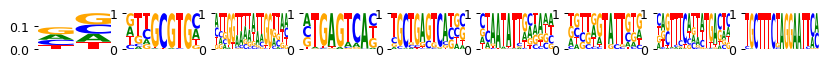

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:50<00:00, 29.06s/it]


Current time: 2024-06-13 02:01:41.264556
	Loss: 238.822 , R2: 0.566
	Training time (model/function): (290.635s / 290.635s)
		per epoch (model/function): (32.293s/ 32.293s)
		per 1k samples: 16.577s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:10<00:00, 27.54s/it]


Current time: 2024-06-13 02:10:56.450244
	Loss: 172.173 , R2: 0.566
	Training time (model/function): (841.483s / 550.848s)
		per epoch (model/function): (44.289s/ 28.992s)
		per 1k samples: 14.883s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:59<00:00, 27.00s/it]


Current time: 2024-06-13 02:20:00.563781
	Loss: 151.896 , R2: 0.566
	Training time (model/function): (1381.521s / 540.038s)
		per epoch (model/function): (72.712s/ 28.423s)
		per 1k samples: 14.591s
best loss 151.896
last five r2 values, by sequential filter optimization: ['0.566']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonL

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:54<00:00, 26.71s/it]


Current time: 2024-06-13 02:29:02.737145
	Loss: 150.794 , R2: 0.566
	Training time (model/function): (1915.772s / 534.251s)
		per epoch (model/function): (100.830s/ 28.118s)
		per 1k samples: 14.435s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:57<00:00, 26.88s/it]


Current time: 2024-06-13 02:38:04.466490
	Loss: 145.570 , R2: 0.566
	Training time (model/function): (2453.448s / 537.676s)
		per epoch (model/function): (129.129s/ 28.299s)
		per 1k samples: 14.527s
best loss 145.570
last five r2 values, by sequential filter optimization: ['0.566', '0.566']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.29s/it]


Current time: 2024-06-13 02:41:37.950551
	Loss: 148.918 , R2: 0.566
	Training time (model/function): (2659.485s / 206.037s)
		per epoch (model/function): (139.973s/ 10.844s)
		per 1k samples: 5.567s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.38s/it]


Current time: 2024-06-13 02:44:09.627303
	Loss: 145.009 , R2: 0.566
	Training time (model/function): (2807.178s / 147.693s)
		per epoch (model/function): (147.746s/ 7.773s)
		per 1k samples: 3.990s
best loss 145.009
last five r2 values, by sequential filter optimization: ['0.566', '0.566', '0.566']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , cr

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.37s/it]


Current time: 2024-06-13 02:46:45.242275
	Loss: 148.754 , R2: 0.566
	Training time (model/function): (2954.604s / 147.426s)
		per epoch (model/function): (155.505s/ 7.759s)
		per 1k samples: 3.983s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.36s/it]


Current time: 2024-06-13 02:49:16.417047
	Loss: 144.963 , R2: 0.566
	Training time (model/function): (3101.892s / 147.288s)
		per epoch (model/function): (163.257s/ 7.752s)
		per 1k samples: 3.979s
best loss 144.960
last five r2 values, by sequential filter optimization: ['0.566', '0.566', '0.566', '0.566']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9957568333195106, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 3101.8920636177063s
Time per epoch (total): 0.539 s
True
12
order None
0 out of 288...
break


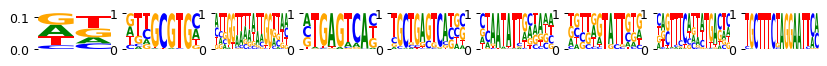

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 10 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.58it/s]


Current time: 2024-06-13 02:49:29.760942
	Loss: 227.034 , R2: 0.566
	Training time (model/function): (4.014s / 4.014s)
		per epoch (model/function): (0.446s/ 0.446s)
		per 1k samples: 0.229s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.66it/s]


Current time: 2024-06-13 02:49:41.144326
	Loss: 172.171 , R2: 0.567
	Training time (model/function): (11.597s / 7.583s)
		per epoch (model/function): (0.610s/ 0.399s)
		per 1k samples: 0.205s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.49it/s]


Current time: 2024-06-13 02:49:53.171770
	Loss: 151.898 , R2: 0.565
	Training time (model/function): (19.711s / 8.114s)
		per epoch (model/function): (1.037s/ 0.427s)
		per 1k samples: 0.219s
best loss 151.898
last five r2 values, by sequential filter optimization: ['0.566']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
ep

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.43it/s]


Current time: 2024-06-13 02:50:09.620017
	Loss: 150.811 , R2: 0.565
	Training time (model/function): (28.044s / 8.333s)
		per epoch (model/function): (1.476s/ 0.439s)
		per 1k samples: 0.225s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Current time: 2024-06-13 02:50:21.497553
	Loss: 145.564 , R2: 0.565
	Training time (model/function): (35.843s / 7.799s)
		per epoch (model/function): (1.886s/ 0.410s)
		per 1k samples: 0.211s
best loss 145.564
last five r2 values, by sequential filter optimization: ['0.566', '0.567']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: Poisso

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.59it/s]


Current time: 2024-06-13 02:50:37.333926
	Loss: 148.945 , R2: 0.567
	Training time (model/function): (43.640s / 7.797s)
		per epoch (model/function): (2.297s/ 0.410s)
		per 1k samples: 0.211s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.40it/s]


Current time: 2024-06-13 02:50:49.813718
	Loss: 145.011 , R2: 0.567
	Training time (model/function): (52.053s / 8.413s)
		per epoch (model/function): (2.740s/ 0.443s)
		per 1k samples: 0.227s
best loss 145.011
last five r2 values, by sequential filter optimization: ['0.566', '0.567', '0.567']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349}
filters mask None
optimizer:  Adam , criterio

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.69it/s]


Current time: 2024-06-13 02:51:05.418657
	Loss: 148.783 , R2: 0.566
	Training time (model/function): (59.574s / 7.521s)
		per epoch (model/function): (3.135s/ 0.396s)
		per 1k samples: 0.203s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 20 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.68it/s]


Current time: 2024-06-13 02:51:17.001931
	Loss: 144.962 , R2: 0.566
	Training time (model/function): (67.125s / 7.552s)
		per epoch (model/function): (3.533s/ 0.397s)
		per 1k samples: 0.204s
best loss 144.962
last five r2 values, by sequential filter optimization: ['0.566', '0.567', '0.567', '0.567']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9929681197224759, pvalue=0.0))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 67.12540078163147s
Time per epoch (total): 0.012 s


In [153]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 10
n_epochs_kernel = 20
log_each=75
n_unfreeze_kernels=70

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train, n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                n_unfreeze_kernels=n_unfreeze_kernels,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [154]:
lib_sizes = train.dataset.rounds.sum(axis=0).flatten()

In [155]:
model.device

device(type='cuda', index=0)

In [156]:
for use_logdynamic in [False, True]:
    p = 'noack_2022_use_logdynamic_%i_obs%i.pth' % (use_logdynamic, ad.shape[0])
    print(p)
    torch.save(model_by_logdynamic[use_logdynamic], p)

noack_2022_use_logdynamic_0_obs7468.pth
noack_2022_use_logdynamic_1_obs7468.pth


In [157]:
ad.shape

(7468, 1948)

In [158]:
ad.write('noack_2022_sample_train_obs%i.h5ad' % ad.shape[0])

In [159]:
import pickle
pickle.dump(train, open('train_dataloader_obs%i.pkl' % ad.shape[0], 'wb'))

: 